<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S6/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR,OneCycleLR

from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt


import sys
import os

py_file_location = '/content/drive/MyDrive/Colab Notebooks/'
sys.path.append(os.path.abspath(py_file_location))

import model
from model import Net


In [3]:
!pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


# Split Dataset into Train set and Test set

In [4]:
train_set = datasets.MNIST('/content/drive/MyDrive/Colab Notebooks/mnist_data/', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                                       transforms.RandomRotation((-7.5, 7.5), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ]))


test_set = datasets.MNIST('/content/drive/MyDrive/Colab Notebooks/mnist_data/', 
                   train=False, 
                   download=True,
                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ]))

# Create Data Loaders for Train and Test set

In [5]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)

batch_size=128

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

# Define Train and Test Functions

In [6]:
lambda_l1 = 0.0001

def train(model, device, train_loader, optimizer, epoch, l1_loss):
    training_losses = []
    training_accuracy = []
    model.train()
    correct = 0
    processed = 0
    # lambda_l1 = 0.0001
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        if l1_loss:
          l1 = 0
          for p in model.parameters():
            l1 = l1 + p.abs().sum()
          loss = loss + lambda_l1 * l1
        
        total_loss += loss
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        correct += predictions.eq(target.view_as(predictions)).sum().item()
        processed += len(data)
    training_losses.append(total_loss)
    training_accuracy.append(100*correct/processed)
    print('Loss = ', loss)
    if l1_loss:
      print('L1 = ', l1)
    print('Train set: Accuracy={:0.1f}'.format(100*correct/processed))
    return training_losses, training_accuracy



def test(model, device, test_loader):
    testing_losses = []
    testing_accuracy = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            predictions = output.argmax(dim=1, keepdim=True)
            correct += predictions.eq(target.view_as(predictions)).sum().item()

    test_loss /= len(test_loader.dataset)
    testing_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    testing_accuracy.append(100. * correct / len(test_loader.dataset))
    return testing_losses, testing_accuracy
  
def eval(model, test_loader):
  model.eval()
  test_loss = 0.0
  correct = 0
  im_pred = {'Wrong': []}
  i = 1
  plt_dt = dict()
  with torch.no_grad():
      for data, target in test_loader:
          if (len(im_pred['Wrong'])<20):
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()
              i+=1
              plt_dt['Input'], plt_dt['target'], plt_dt['pred'] = data.to('cpu'), target.to('cpu'), pred.to('cpu').view(-1,)

              for id in range(len(data)):
                  if plt_dt['target'][id] != plt_dt['pred'][id]:
                      im_pred['Wrong'] = im_pred['Wrong']+ [{'Image':data[id],'pred':pred[id],'actual' : target[id]}]
  
  plt.figure(figsize=(14,14)) 
  for i in range(20):
      plt.subplot(4,5,i+1)  
      pixels = np.array(im_pred['Wrong'][i]['Image'].cpu() , dtype='uint8')

      # Reshape the array into 28 x 28 array (2-dimensional array)
      pixels = pixels.reshape((28, 28))

      # Plot
      plt.title('Actual Value is {label}\n Predicted Value is {pred}'.format(label=im_pred['Wrong'][i]['actual'].cpu(), pred =im_pred['Wrong'][i]['pred'].cpu()[0]), color='r')
      plt.imshow(pixels, cmap='gray')

  plt.show()


*   Model Initialization and Summary - Print the model parameters and output shape at each layer by giving dummy input to torchsummary.
*   Train and Test the Model - Initialize the Optimizers, loss, use LR Scheduling etc and execute the training Loop and collect loss and accuracy for further plotting the graphs.

*   Evaluate the results.



 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
         GroupNorm-2           [-1, 32, 28, 28]              64
           Dropout-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             320
            Conv2d-6           [-1, 10, 28, 28]             900
         GroupNorm-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
              ReLU-9           [-1, 10, 28, 28]               0
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 12, 12]             900
        GroupNorm-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
             ReLU-14           [-1, 10,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss =  tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(604.2025, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=80.9
training_l_g:  [tensor(360.7826, device='cuda:0', grad_fn=<AddBackward0>)]
Test set: Average loss: 0.1294, Accuracy: 9686/10000 (96.9%)

EPOCH: 2 LR =  [0.01]
Loss =  tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(625.9624, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=96.8
training_l_g:  [tensor(87.1688, device='cuda:0', grad_fn=<AddBackward0>)]
Test set: Average loss: 0.0706, Accuracy: 9817/10000 (98.2%)

EPOCH: 3 LR =  [0.01]
Loss =  tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(633.4707, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=97.5
training_l_g:  [tensor(70.5745, device='cuda:0', grad_fn=<AddBackward0>)]
Test set: Average loss: 0.0546, Accuracy: 9846/10000 (98.5%)

EPOCH: 4 LR =  [0.01]
Loss =  tensor(0.2149, device='cuda:0', grad_fn=<AddBackward0>)
L1

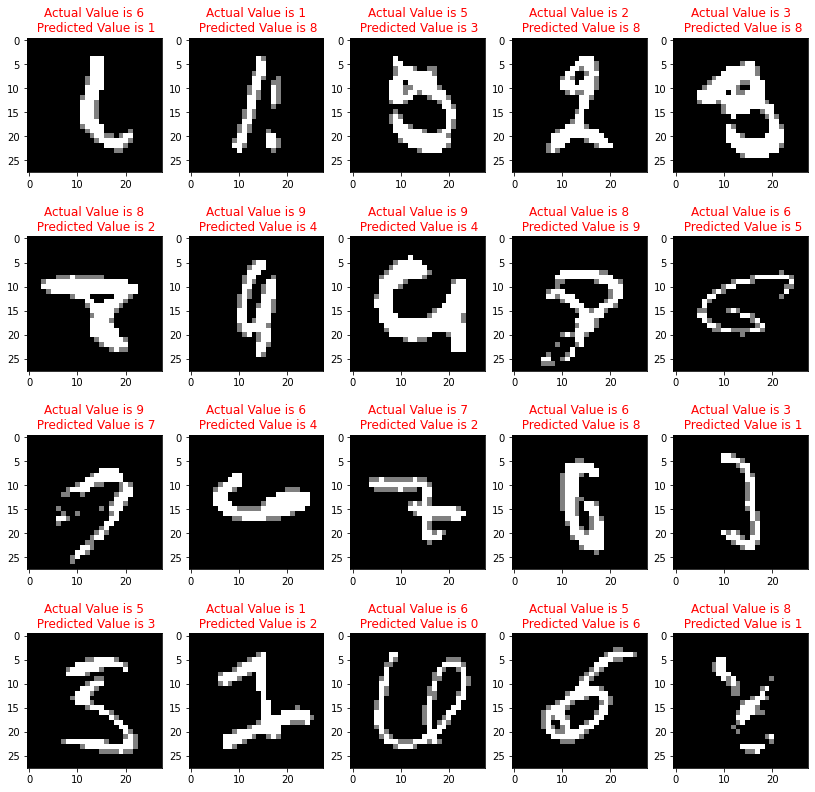

In [7]:
# will be used while plotting graphs
training_losses_group = []
testing_losses_group = []
training_accuracy_group = []
testing_accuracy_group = []

model_group = Net("group").to(device)
print(summary(model_group, input_size=(1, 28, 28)))
optimizer_group = optim.SGD(model_group.parameters(), lr=0.01, momentum=0.9)
scheduler_group = StepLR(optimizer_group, step_size=6, gamma=0.1)

for epoch in range(1, 20):
    print("EPOCH:", epoch, "LR = ", scheduler_group.get_lr())
    training_l_g, training_a_g = train(model_group, device, train_loader, optimizer_group, epoch, l1_loss= True)
    print("training_l_g: ",training_l_g)
    testing_l_g, testing_a_g = test(model_group, device, test_loader)
    scheduler_group.step()
    training_losses_group.extend(training_l_g)
    # print("training_losses_group: ",training_losses_group)
    testing_losses_group.extend(testing_l_g)
    # print("testing_losses_group: ",testing_losses_group)
    training_accuracy_group.append(training_a_g)
    testing_accuracy_group.append(testing_a_g)

eval(model_group, test_loader)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
         GroupNorm-2           [-1, 32, 28, 28]              64
           Dropout-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             320
            Conv2d-6           [-1, 10, 28, 28]             900
         GroupNorm-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
              ReLU-9           [-1, 10, 28, 28]               0
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 12, 12]             900
        GroupNorm-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
             ReLU-14           [-1, 10,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss =  tensor(0.0864, device='cuda:0', grad_fn=<NllLossBackward>)
Train set: Accuracy=82.5
Test set: Average loss: 0.0932, Accuracy: 9779/10000 (97.8%)

EPOCH: 2 LR =  [0.01]
Loss =  tensor(0.0991, device='cuda:0', grad_fn=<NllLossBackward>)
Train set: Accuracy=96.9
Test set: Average loss: 0.0616, Accuracy: 9842/10000 (98.4%)

EPOCH: 3 LR =  [0.01]
Loss =  tensor(0.0467, device='cuda:0', grad_fn=<NllLossBackward>)
Train set: Accuracy=97.7
Test set: Average loss: 0.0612, Accuracy: 9824/10000 (98.2%)

EPOCH: 4 LR =  [0.01]
Loss =  tensor(0.0922, device='cuda:0', grad_fn=<NllLossBackward>)
Train set: Accuracy=97.9
Test set: Average loss: 0.0653, Accuracy: 9814/10000 (98.1%)

EPOCH: 5 LR =  [0.01]
Loss =  tensor(0.0615, device='cuda:0', grad_fn=<NllLossBackward>)
Train set: Accuracy=98.2
Test set: Average loss: 0.0441, Accuracy: 9870/10000 (98.7%)

EPOCH: 6 LR =  [0.01]
Loss =  tensor(0.0254, device='cuda:0', grad_fn=<NllLossBackward>)
Train set: Accuracy=98.3
Test set: Average loss: 0.04

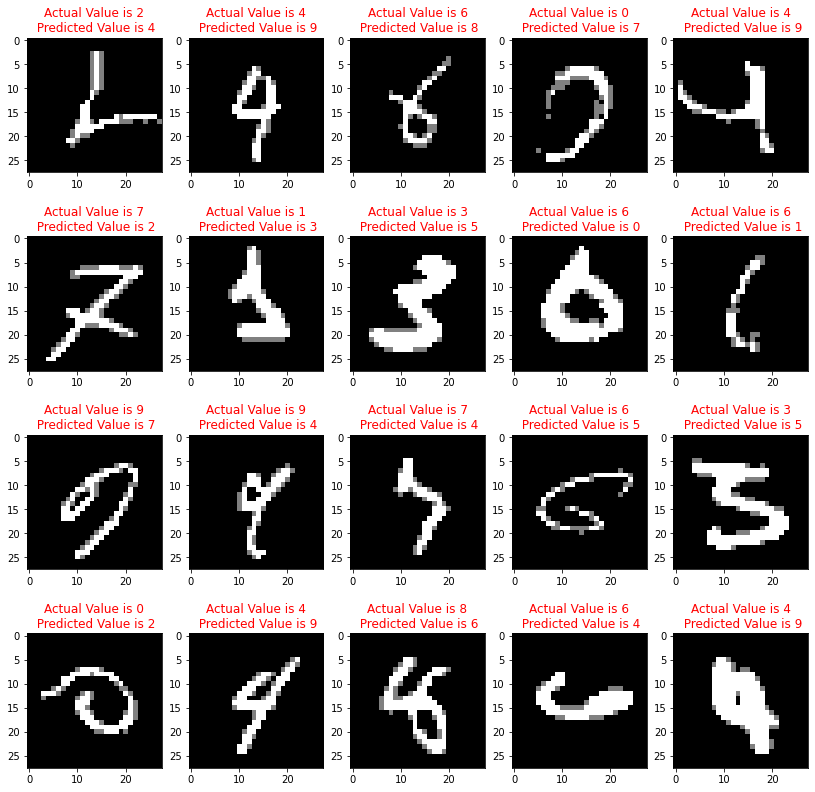

In [8]:
# will be used while plotting graphs
training_losses_layer = []
testing_losses_layer = []
training_accuracy_layer = []
testing_accuracy_layer = []


model_layer = Net("layer").to(device)
print(summary(model_layer, input_size=(1, 28, 28)))
optimizer_layer = optim.SGD(model_layer.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler_layer = StepLR(optimizer_layer, step_size=6, gamma=0.1)

for epoch in range(1, 20):
    print("EPOCH:", epoch, "LR = ", scheduler_layer.get_lr())
    training_l_l, training_a_l = train(model_layer, device, train_loader, optimizer_layer, epoch, l1_loss= False)
    testing_l_l, testing_a_l = test(model_layer, device, test_loader)
    scheduler_layer.step()
    training_losses_layer.extend(training_l_l)
    testing_losses_layer.extend(testing_l_l)
    training_accuracy_layer.extend(training_a_l)
    testing_accuracy_layer.extend(testing_a_l)

eval(model_layer, test_loader)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
           Dropout-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             320
            Conv2d-6           [-1, 10, 28, 28]             900
       BatchNorm2d-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
              ReLU-9           [-1, 10, 28, 28]               0
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 12, 12]             900
      BatchNorm2d-12           [-1, 10, 12, 12]              20
          Dropout-13           [-1, 10, 12, 12]               0
             ReLU-14           [-1, 10,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss =  tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(534.7310, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=86.3
Test set: Average loss: 0.0809, Accuracy: 9788/10000 (97.9%)

EPOCH: 2 LR =  [0.01]
Loss =  tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(515.7218, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=98.0
Test set: Average loss: 0.0629, Accuracy: 9844/10000 (98.4%)

EPOCH: 3 LR =  [0.01]
Loss =  tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(493.6898, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=98.3
Test set: Average loss: 0.0436, Accuracy: 9886/10000 (98.9%)

EPOCH: 4 LR =  [0.01]
Loss =  tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)
L1 =  tensor(472.8331, device='cuda:0', grad_fn=<AddBackward0>)
Train set: Accuracy=98.5
Test set: Average loss: 0.0361, Accuracy: 9909/10000 (99.1%)

EPOCH: 5 LR =  [0.01]
Loss =  tensor(0.0696, device='cuda:0', grad_fn=<Add

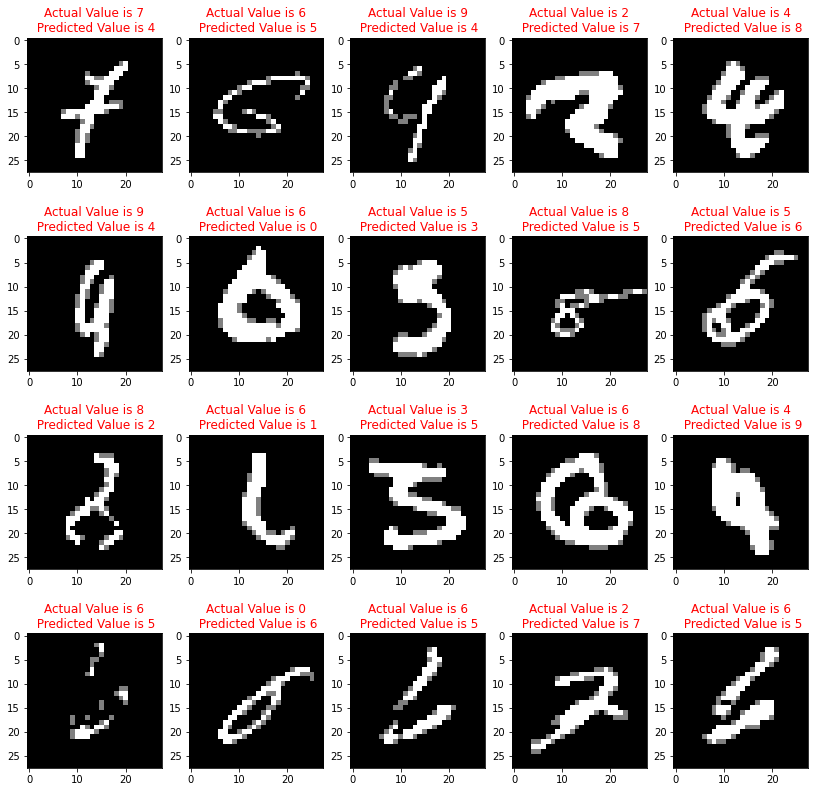

In [9]:
# will be used while plotting graphs
training_losses_batch= []
testing_losses_batch = []
training_accuracy_batch = []
testing_accuracy_batch = []


model_batch = Net("batch").to(device)
print(summary(model_batch, input_size=(1, 28, 28)))
optimizer_batch = optim.SGD(model_batch.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler_batch = StepLR(optimizer_batch, step_size=6, gamma=0.1)

for epoch in range(1, 20):
    print("EPOCH:", epoch, "LR = ", scheduler_batch.get_lr())
    training_l_b, training_a_b = train(model_batch, device, train_loader, optimizer_batch, epoch, l1_loss= True)
    testing_l_b, testing_a_b = test(model_batch, device, test_loader)
    scheduler_batch.step()
    training_losses_batch.extend(training_l_b)
    testing_losses_batch.extend(testing_l_b)
    training_accuracy_batch.extend(training_a_b)
    testing_accuracy_batch.extend(testing_a_b)

eval(model_batch, test_loader)


### Plotting Training Loss per Epoch

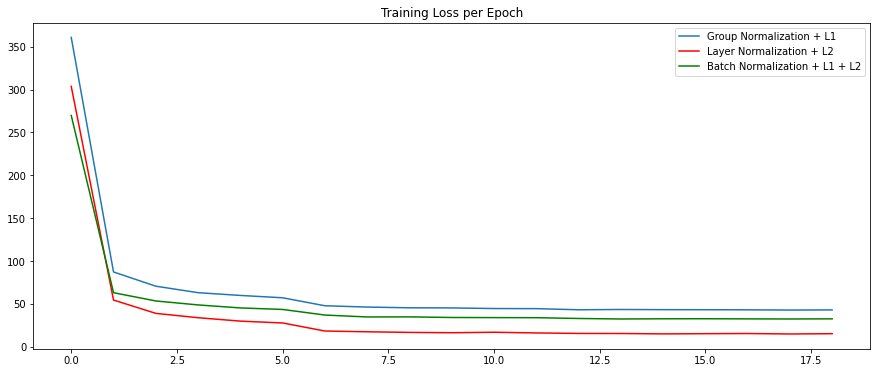

In [11]:
plt.rcParams['figure.figsize'] = [15, 6]

def plotting_curves(model1, model2, model3, legend, title):
  plt.plot(np.array(model1))
  plt.plot(np.array(model2), 'r')
  plt.plot(np.array(model3), 'g')
  plt.legend(legend)
  plt.title(title)

plotting_curves(training_losses_group, training_losses_layer, training_losses_batch, ['Group Normalization + L1', 'Layer Normalization + L2', 'Batch Normalization + L1 + L2'], 'Training Loss per Epoch')

### Plotting Test Loss per Epoch

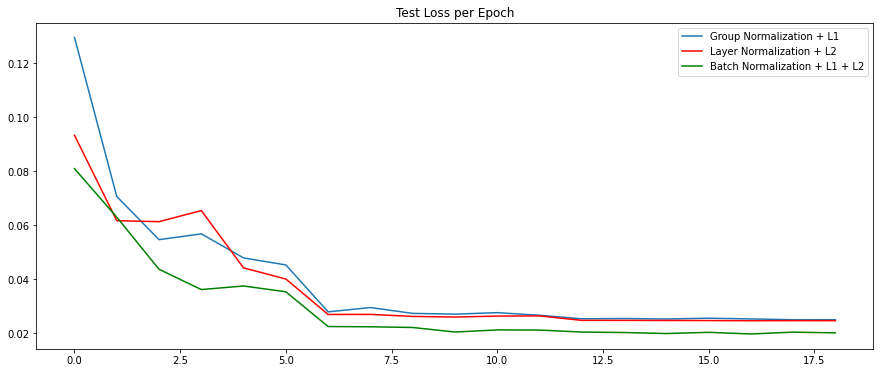

In [12]:
plotting_curves(testing_losses_group, testing_losses_layer, testing_losses_batch, ['Group Normalization + L1', 'Layer Normalization + L2', 'Batch Normalization + L1 + L2'], 'Test Loss per Epoch')

### Plotting Test Accuracy per Epoch

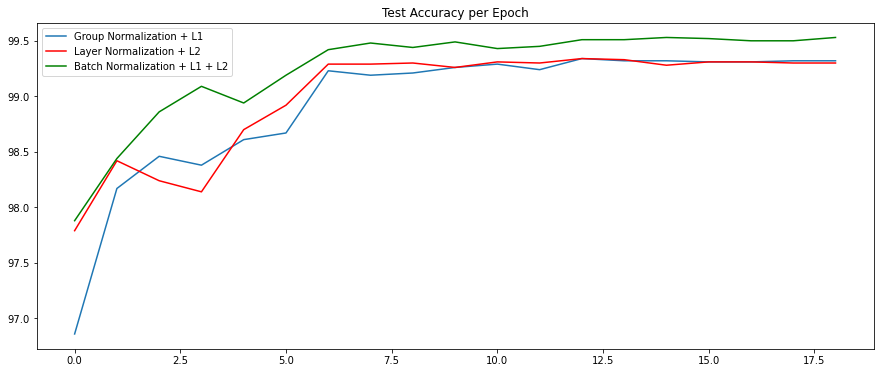

In [13]:
plotting_curves(testing_accuracy_group, testing_accuracy_layer, testing_accuracy_batch, ['Group Normalization + L1', 'Layer Normalization + L2', 'Batch Normalization + L1 + L2'], 'Test Accuracy per Epoch')

### Plotting Training Accuracy per Epoch

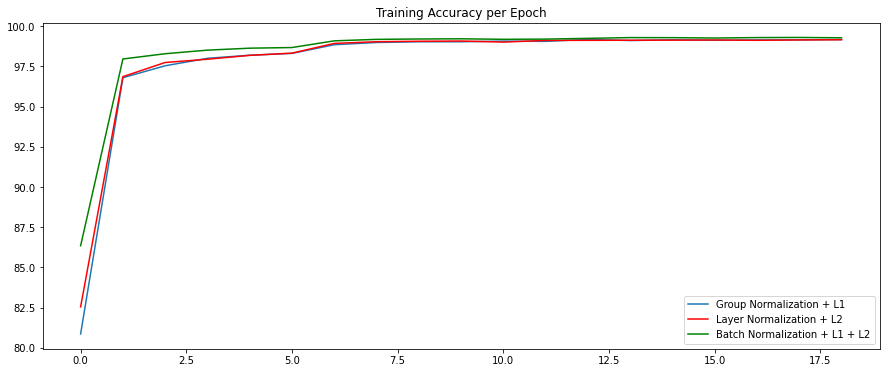

In [14]:
plotting_curves(training_accuracy_group, training_accuracy_layer, training_accuracy_batch, ['Group Normalization + L1', 'Layer Normalization + L2', 'Batch Normalization + L1 + L2'], 'Training Accuracy per Epoch')